## Author: Alexander Goudemond, Student Number: 219030365

# Neural Networks

This notebook will attempt to train some Neural Networks on the Training data and save it for later use

In this notebook, we are going to begin looking at training some neural networks.

After trying several UNet Tutorials, I have learnt of several problems that I have had to overcome:

- The online tutorial data-sets are either not clean or not accessible (hosted on private servers or websites, like Kaggle, Medium, PyImageSearch)

- The implementation is complicated and/or built on old dependencies, meaning that modifying the architecture results in problems that are difficult to fix

- For offline training - The laptop I am using is not powerful enough, as the Graphics Card does not have enough VRAM

- The DataSet I have been using was not properly prepared for Training. One such problem was that the Masks were pixelated, as a result of being saved as JPG images early on

- An additional problem with my datasets is that the number of classes in each of my masks is not consistent - each cell seems to be allocated a unique class, across all images

Here is how I have designed the environment to circumvent these problems:

- Offline, I generate folders for Training (Images and there corresponding Masks) The images are in colour, whereas the masks are grasycale

- I upload the 2 Training folders onto Google Drive

- I use UNet architectures that seemed to work in the past. One is a pretrained model, which I retrain and the other uses Patchify to crop and slice the images into smaller pieces

In addition to all of the above, I have learnt some more things:

- The images that go into my model need to have pixels in the range [0, 1]. If the pixels are in the range [0, 255], then I experience issues with my loss function being NaN

- The measurement of accuracy in this model may not be sufficient, as there is the possibility that >90% of my image is black - meaning that any model classifiying a pixel as black will have a high accuracy. Instead, I may need to use other metrics, like MeanIOU score and focus on the Loss value instead

- Some of my original images may contain additional information that confuses the system (such as the Petri Dish in the first few folders). I may need to return to my previous work and see if there exists other pre-processing steps to try remove undesirable information...

The focus of this notebook is the following:

- Load the images from 1 dedicated dataset into the notebook

- use Patchify to crop them into 224 X 224 pieces

- reduce the number of classes from a multiclass problem to a binary problem (Any class above 0 is automatically a 1)

- Train the model

- use MeanIOU to calculate success rate

In this notebook, we explore training the Pre-Trained Model from the Tensorflow website on 1 DataSet, and make us of the patchify tutorial from Dr. Sreenivas Bhattiprolu.

Tensorflow link:

https://www.tensorflow.org/tutorials/images/segmentation 

Dr. Sreenivas Bhattiprolu:

https://github.com/bnsreenu/python_for_microscopists/tree/master/228_semantic_segmentation_of_aerial_imagery_using_unet

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Please ensure the following folders exist

drive > MyDrive > COMP700_Images > COMP700_Processed_Training_GT

drive > MyDrive > COMP700_Images > COMP700_Processed_Training_ST

drive > MyDrive > COMP700_Images > COMP700_Raw_Training_GT

drive > MyDrive > COMP700_Images > COMP700_Raw_Training_ST

drive > MyDrive > COMP700_Neural_Network_Code

The latter location is where the Jupyter Notebooks will be loaded, and the former directories will contain the images used. These images are generated offline by the other notebooks and then uploaded to Google Drive

# Installs

In [ ]:
!pip install patchify
!pip install segmentation-models
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-tst161wf
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-tst161wf


# Imports

In [ ]:
from os import getcwd, walk, mkdir, stat, remove
from os import sep # used later on, in a function, to print directory contents
from os.path import exists, basename, join

from shutil import copyfile

from PIL.Image import fromarray
import cv2

import matplotlib.pyplot as plt
import numpy as np

from patchify import patchify

import segmentation_models as sm

import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow import keras
from keras.layers import Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Input, Lambda
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from IPython.display import clear_output


# Verify that files exist

We will be going to our training data and fetching 1 folder for our x and y training variables. Once that is successful, we will explore training on each of the datasets together

In [ ]:
getcwd()

'/content'

Let's do a sanity check before continuing:

In [ ]:
google_drive_path = "/drive/MyDrive"
training_data_folder = "COMP700_Processed_Training_GT"
training_data_directory = getcwd() + google_drive_path + "/COMP700_Images/"

In [ ]:
training_data_directory

'/content/drive/MyDrive/COMP700_Images/'

In [ ]:
# "COMP700_Processed_Training_ST"
st_x_dirs = []
st_y_dirs = []
st_x_length = []
st_y_length = []

for root, dirs, files in walk(training_data_directory + "COMP700_Processed_Training_ST"):
    # print(dirs)
    if ("X" in dirs or "Y" in dirs):
        # print("yes", root)
        for root2, dirs2, files2 in walk(root + "/X"):
            st_x_dirs.append(root2[-20 : ])
            st_x_length.append(len(files2))

        for root2, dirs2, files2 in walk(root + "/Y"):
            st_y_dirs.append(root2[-20 : ])
            st_y_length.append(len(files2))

In [ ]:
print(st_x_length)
print(st_y_length)
print()
#uncomment if sizes dont match, and find problem dataset
# print(st_x_dirs)
# print(st_y_dirs)


[115, 115, 84, 84, 92, 92, 300, 300, 92, 92, 1764, 1764, 1378, 1386, 48, 48]
[115, 115, 84, 84, 92, 92, 300, 300, 92, 92, 1764, 1764, 1376, 1386, 48, 48]



In [ ]:
# "COMP700_Processed_Training_GT"
gt_x_dirs = []
gt_y_dirs = []
gt_x_length = []
gt_y_length = []

for root, dirs, files in walk(training_data_directory + "COMP700_Processed_Training_GT"):
    # print(dirs)
    if ("X" in dirs or "Y" in dirs):
        # print("yes", root)
        for root2, dirs2, files2 in walk(root + "/X"):
            gt_x_dirs.append(root2[-20 : ])
            gt_x_length.append(len(files2))

        for root2, dirs2, files2 in walk(root + "/Y"):
            gt_y_dirs.append(root2[-20 : ])
            gt_y_length.append(len(files2))


In [ ]:
print(gt_x_length)
print(gt_y_length)
print()
#uncomment if sizes dont match, and find problem dataset
# print(gt_x_dirs)
# print(gt_y_dirs)


[2, 2, 5, 8, 50, 50, 9, 9, 150, 65, 15, 19, 8, 49, 8, 28, 33, 18, 30, 20]
[2, 2, 5, 8, 50, 50, 9, 9, 150, 65, 15, 19, 8, 49, 8, 28, 33, 18, 30, 20]



# Load image paths variables

We know that each directory contains 2 folders: X and Y, and we want a specific dataset here: Fluo-C2DL-MSC

In [ ]:
google_drive_path = "/drive/MyDrive"
training_data_folder = "COMP700_Processed_Training_GT"
training_data_directory = getcwd() + google_drive_path + "/COMP700_Images/" + training_data_folder
desired_directory = ""

maxLength = -1
length = 0

# look for largest length
for root, dirs, files in walk(training_data_directory):
    if ("Fluo-C2DL-Huh7" in root):
        desired_directory = root

print(desired_directory)


/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/X


Let's remove the X and prepare the data for training:

In [ ]:
desired_directory = desired_directory[ : -2]

desired_directory

'/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01'

In [ ]:
x_training_paths = []
y_training_paths = []

# should only execute twice
for root, dirs, files in walk(desired_directory):
    if ("X" in root):
        x_training_paths = files # entire array loaded
    elif ("Y" in root):
        y_training_paths = files # entire array loaded

print("Length of X Training:", len(x_training_paths))
print("Length of Y Training:", len(y_training_paths))

# update the paths:

for i in range(len(x_training_paths)):
    x_training_paths[i] = desired_directory + "/X/" + x_training_paths[i]
    y_training_paths[i] = desired_directory + "/Y/" + y_training_paths[i]

Length of X Training: 8
Length of Y Training: 8


What do the paths look like?

In [ ]:
x_training_paths[0:10]

['/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/X/processed1_t006.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/X/processed1_t000.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/X/processed1_t025.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/X/processed1_t027.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/X/processed1_t002.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/X/processed1_t015.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/X/processed1_t019.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/X/processed1_t014.tif']

In [ ]:
y_training_paths[0:10]

['/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/Y/man_seg000.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/Y/man_seg014.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/Y/man_seg019.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/Y/man_seg006.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/Y/man_seg027.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/Y/man_seg015.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/Y/man_seg002.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/Y/man_seg025.png']

We recognize that the images do not correspond, this is because Drive may save them via a HashMap. Let us sort them and re-look:

In [ ]:
x_training_paths.sort()
y_training_paths.sort()

In [ ]:
x_training_paths[0:10]

['/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/X/processed1_t000.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/X/processed1_t002.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/X/processed1_t006.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/X/processed1_t014.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/X/processed1_t015.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/X/processed1_t019.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/X/processed1_t025.tif',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/X/processed1_t027.tif']

In [ ]:
y_training_paths[0:10]

['/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/Y/man_seg000.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/Y/man_seg002.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/Y/man_seg006.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/Y/man_seg014.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/Y/man_seg015.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/Y/man_seg019.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/Y/man_seg025.png',
 '/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-C2DL-Huh7/Fluo-C2DL-Huh7/01/Y/man_seg027.png']

# View sample Image and Masks - before and after resizing

Let us see the images together, before and after resizing:

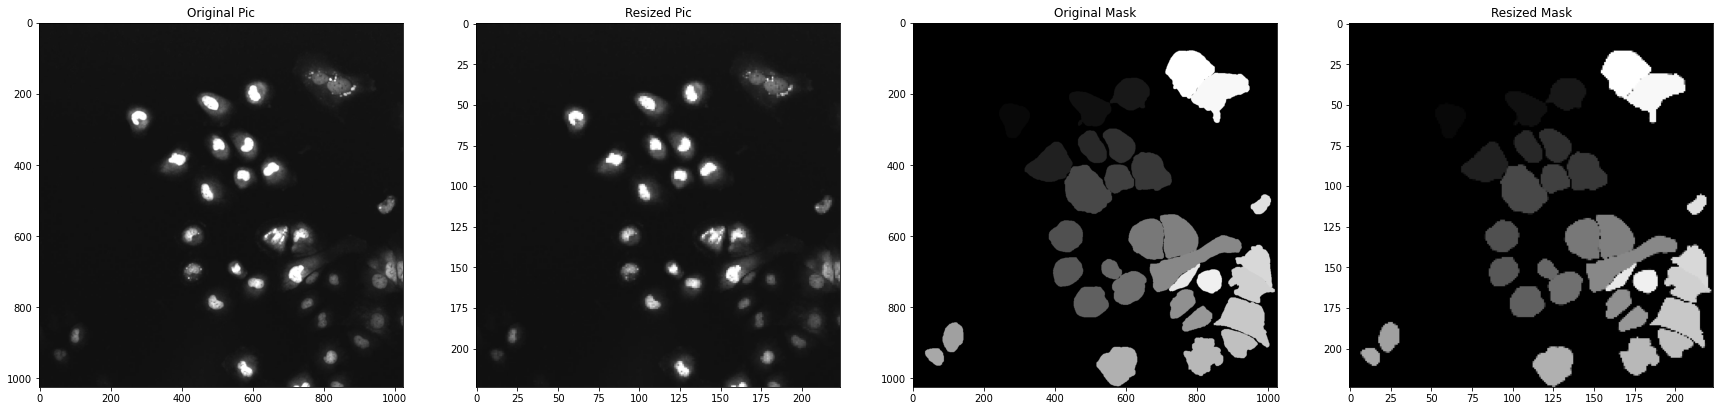

In [ ]:
# Let's now try show these images side by side to verify results:

from random import randint

# 1604 is a good recurring example
index = randint(0, len(x_training_paths) - 1)
dim = (224, 224)

fig = plt.figure(figsize=(30,8))

plt.subplot(1, 4, 1)
original_pic = img = cv2.imread( x_training_paths[index] )
plt.imshow(original_pic)
plt.title("Original Pic")

plt.subplot(1, 4, 2)
resized_pic = cv2.resize( cv2.imread( x_training_paths[index] ) , dim)
plt.imshow(resized_pic)
plt.title("Resized Pic")

plt.subplot(1, 4, 3)
original_mask = cv2.imread( y_training_paths[index] , cv2.IMREAD_GRAYSCALE)
plt.imshow(original_mask, cmap="gray")
plt.title("Original Mask")

plt.subplot(1, 4, 4)
resized_mask = cv2.resize( cv2.imread( y_training_paths[index], cv2.IMREAD_GRAYSCALE) , dim)
plt.imshow(resized_mask, cmap="gray")
plt.title("Resized Mask")

plt.show()

let us also check the number of distinct pixels in those images:


In [ ]:
print("Distinct Pixels in Original Pic:",  len(np.unique( original_pic  )))
print("Distinct Pixels in Resized Pic:",   len(np.unique( resized_pic   )))
print("Distinct Pixels in Oringal Mask:",  len(np.unique( original_mask )))
print("Distinct Pixels in Resized Mask:",  len(np.unique( resized_mask  )))

Distinct Pixels in Original Pic: 241
Distinct Pixels in Resized Pic: 241
Distinct Pixels in Oringal Mask: 33
Distinct Pixels in Resized Mask: 186


Visually, we can see that we are losing quality by resizing the image. Our mask also has an increase in the number of classes

So, we will not resize, and instead use Patchify to cut the images into more manageable pieces

The cropped images will be generated next in the notebook, thereafter we can train the models. 

# Partition Training Data

Because our training data is so small, we can use a model of size (128, 128) here. Patchify should generate enough data for us to use



In [ ]:
from sklearn.model_selection import train_test_split

x_train_paths, x_test_paths, \
y_train_paths, y_test_paths = train_test_split(
                                              x_training_paths, 
                                              y_training_paths, 
                                              test_size=0.2, 
                                              random_state=4
                                              )


In [ ]:
print(len(x_train_paths))
print(len(y_train_paths))
print(len(x_test_paths))
print(len(y_test_paths))

6
6
2
2


# Crop and Patchify images

Let's declare our scaler and patch size

In [ ]:
scaler = MinMaxScaler()
patch_size = 128

Now, we need to go through each of the images in x_image_paths and patchify them

In [ ]:
def extractRHS(string, symbol):
    index = string.rfind(symbol)
    # print(index)
    return string[ index + 1 : ]
###

extractRHS("219030365@stu.ukzn.zc.za", "@")

'stu.ukzn.zc.za'

In [ ]:
# from PIL.Image import fromarray

#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
# image_dataset = np.array([])  
image_dataset = []
count = 0
length = len(x_training_paths)

for path in x_training_paths:
  count += 1
  image = cv2.imread(path, 1) # read as BGR

  # print("Old Shape:", image.shape, end="; ")

  SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
  SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size

  # print(SIZE_X, ":", SIZE_Y)

  image = fromarray(image)
  image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
  #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
  image = np.array(image)

  # print("New Shape:", image.shape)

  #Extract patches from each image
  print("Now patchifying image:", extractRHS(path, "/") , "-->", count, "/", length)
  patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      
      single_patch_img = patches_img[i,j,:,:]
      
      #Use minmaxscaler instead of just dividing by 255. 
      single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
      
      #single_patch_img = (single_patch_img.astype('float32')) / 255. 
      single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds. 

      # img_new = (single_patch_img * 255).astype(int) # scale up values
      img_new = single_patch_img

      # image_dataset = np.append(image_dataset, img_new)
      image_dataset.append(img_new)


Now patchifying image: processed1_t000.tif --> 1 / 8
Now patchifying image: processed1_t002.tif --> 2 / 8
Now patchifying image: processed1_t006.tif --> 3 / 8
Now patchifying image: processed1_t014.tif --> 4 / 8
Now patchifying image: processed1_t015.tif --> 5 / 8
Now patchifying image: processed1_t019.tif --> 6 / 8
Now patchifying image: processed1_t025.tif --> 7 / 8
Now patchifying image: processed1_t027.tif --> 8 / 8


In [ ]:
print("Length original images:", len(x_training_paths))
print("Length of patchified images", len(image_dataset))

Length original images: 8
Length of patchified images 32


In [ ]:
def display(display_list, title=[]):
  plt.figure(figsize=(15, 15))

  # update if title not provided
  if (len(title) == 0):
    title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap="gray")
    plt.axis('off')
  plt.show()


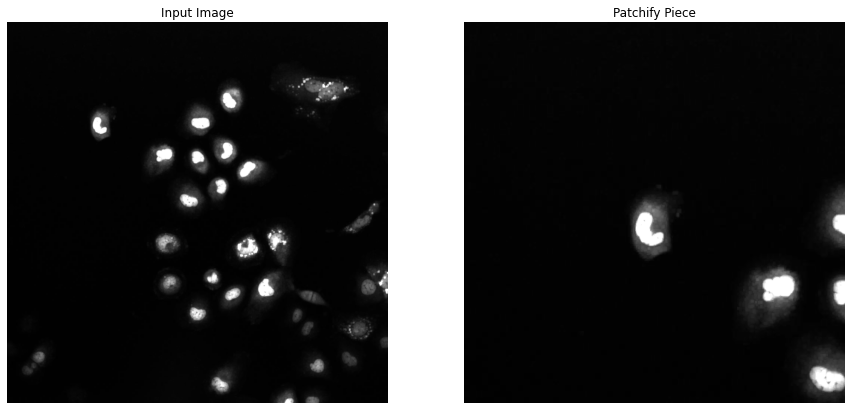

In [ ]:
index = 0
array = [ cv2.imread(x_training_paths[index]), image_dataset[index]]

display(array, ["Input Image", "Patchify Piece"])

As we can see from the above, our patchify images are pieces of the original!

Let us now repeat that for the masks

In [ ]:
#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
# mask_dataset = np,array([])  
mask_dataset = []
count = -1
length = len(y_training_paths)

for path in y_training_paths:
  count += 1
  image = cv2.imread(path, 1) # read as BGR

  # print("Old Shape:", image.shape, end="; ")

  SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
  SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size

  # print(SIZE_X, ":", SIZE_Y)

  image = fromarray(image)
  image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
  #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
  image = np.array(image)

  # print("New Shape:", image.shape)

  #Extract patches from each image
  print("Now patchifying image:", extractRHS(path, "/") , "-->", count, "/", length)
  patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      
      single_patch_img = patches_img[i,j,:,:]
      
      #Use minmaxscaler instead of just dividing by 255. 
      single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
      
      #single_patch_img = (single_patch_img.astype('float32')) / 255. 
      single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds. 

      # img_new = (single_patch_img * 255).astype(int) # scale up values
      img_new = single_patch_img

      # np.append(mask_dataset, img_new)
      mask_dataset.append(img_new)


Now patchifying image: man_seg000.png --> 0 / 8
Now patchifying image: man_seg002.png --> 1 / 8
Now patchifying image: man_seg006.png --> 2 / 8
Now patchifying image: man_seg014.png --> 3 / 8
Now patchifying image: man_seg015.png --> 4 / 8
Now patchifying image: man_seg019.png --> 5 / 8
Now patchifying image: man_seg025.png --> 6 / 8
Now patchifying image: man_seg027.png --> 7 / 8


In [ ]:
print("Length original images:", len(y_training_paths))
print("Length of patchified images", len(mask_dataset))

Length original images: 8
Length of patchified images 32


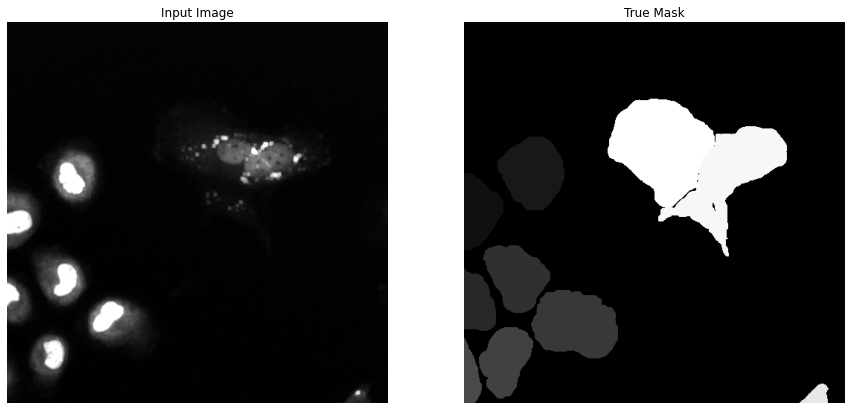

In [ ]:
position = 5
array = [ image_dataset[position], mask_dataset[position] ]

display( array )

Let us double check the unique pixels in our image:

In [ ]:
print(np.unique(image_dataset[position]))

[0.         0.0041841  0.0083682  0.0125523  0.0167364  0.0209205
 0.0251046  0.0292887  0.0334728  0.0376569  0.041841   0.0460251
 0.05020921 0.05439331 0.05857741 0.06276151 0.06694561 0.07112971
 0.07531381 0.07949791 0.08368201 0.08786611 0.09205021 0.09623431
 0.10041841 0.10460251 0.10878661 0.11297071 0.11715481 0.12133891
 0.12552301 0.12970711 0.13389121 0.13807531 0.14225941 0.14644351
 0.15062762 0.15481172 0.15899582 0.16317992 0.16736402 0.17154812
 0.17573222 0.17991632 0.18410042 0.18828452 0.19246862 0.19665272
 0.20083682 0.20502092 0.20920502 0.21338912 0.21757322 0.22175732
 0.22594142 0.23012552 0.23430962 0.23849372 0.24267782 0.24686192
 0.25104603 0.25523013 0.25941423 0.26359833 0.26778243 0.27196653
 0.27615063 0.28033473 0.28451883 0.28870293 0.29288703 0.29707113
 0.30125523 0.30543933 0.30962343 0.31380753 0.31799163 0.32217573
 0.32635983 0.33054393 0.33472803 0.33891213 0.34309623 0.34728033
 0.35146444 0.35564854 0.35983264 0.36401674 0.36820084 0.372384

In [ ]:
print(np.unique(mask_dataset[position]))

[0.         0.0627451  0.09411765 0.15686275 0.18823529 0.21960784
 0.25490196 0.28627451 0.90588235 0.96862745 1.        ]


Let us do a thorough check, throughout each mask and count the unique elements:

In [ ]:
unique_pixels = []

for mask in mask_dataset:
  unique = np.unique(mask)

  for num in unique:
    if (num not in unique_pixels):
      unique_pixels.append(num)

unique_pixels.sort()

print(unique_pixels)
print(len(unique_pixels))

[0.0, 0.06274509803921569, 0.09411764705882353, 0.1095890410958904, 0.1111111111111111, 0.1568627450980392, 0.18823529411764706, 0.2191780821917808, 0.2196078431372549, 0.2222222222222222, 0.25098039215686274, 0.2549019607843137, 0.2823529411764706, 0.28627450980392155, 0.3, 0.305439330543933, 0.4, 0.4090909090909091, 0.4142259414225941, 0.4219653179190751, 0.42857142857142855, 0.43333333333333335, 0.4383561643835616, 0.4444444444444444, 0.4476987447698744, 0.4545454545454546, 0.4666666666666667, 0.4682080924855491, 0.47619047619047616, 0.4811715481171548, 0.5, 0.5144508670520231, 0.5146443514644351, 0.5238095238095237, 0.5333333333333333, 0.5454545454545454, 0.547945205479452, 0.5481171548117154, 0.5555555555555556, 0.5666666666666667, 0.5714285714285714, 0.5722543352601156, 0.5857740585774058, 0.6, 0.6150627615062761, 0.6333333333333333, 0.6527196652719665, 0.7333333333333333, 0.7573221757322175, 0.7666666666666666, 0.7907949790794978, 0.8, 0.8284518828451882, 0.8333333333333334, 0.8

Okay! We can see that this particular dataset has 111 classes in the masks. Let us change that to 2 classes:

# Generate binary class masks

In [ ]:
binary_mask_dataset = []

for mask in mask_dataset:
    temp = mask
    temp[temp > 0.0] = 1.0
    binary_mask_dataset.append( temp )

In [ ]:
unique_pixels_2 = []

for mask in binary_mask_dataset:
  unique = np.unique(mask)

  for num in unique:
    if (num not in unique_pixels_2):
      unique_pixels_2.append(num)

unique_pixels_2.sort()

print(unique_pixels_2)
print(len(unique_pixels_2))

[0.0, 1.0]
2


# Train and Test Data

In [ ]:
print(len(image_dataset))
print(len(binary_mask_dataset))

32
32


In [ ]:
# Because we shuffled earlier, we can just select the first 90% of the data here
partition = (int) (0.9 * len(image_dataset))

x_train = image_dataset[ 0 : partition ]
y_train = mask_dataset[ 0 : partition]

x_test  = image_dataset[ partition : ]
y_test  = mask_dataset[ partition : ]

# Define Model

In [ ]:
INPUT_SIZE = patch_size

base_model = tf.keras.applications.MobileNetV2(input_shape=[INPUT_SIZE, INPUT_SIZE, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]


In [ ]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[INPUT_SIZE, INPUT_SIZE, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [ ]:
random_index = randint(0, len(y_train)-1)

sample_image, sample_mask = x_train[random_index], y_train[random_index]

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


In [ ]:
# def display(display_list):
#   plt.figure(figsize=(15, 15))

#   title = ['Input Image', 'True Mask', 'Predicted Mask']

#   for i in range(len(display_list)):
#     plt.subplot(1, len(display_list), i+1)
#     plt.title(title[i])
#     plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
#     plt.axis('off')
#   plt.show()


In [ ]:
def show_predictions(model, dataset=None):
  if dataset:
    for image, mask in dataset:
      pred_mask = model.predict(image[tf.newaxis, ...])
      display([image, mask, create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])


# Create and Train the Model

In [ ]:
OUTPUT_CLASSES = 3 # notice output classes
tensorflow_model = unet_model(output_channels=OUTPUT_CLASSES)

# RMSprop compiler
tensorflow_model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
tensorflow_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 256, 256, 9  1841984     ['input_2[0][0]']                
                                6),                                                               
                                 (None, 128, 128, 1                                               
                                44),                                                              
                                 (None, 64, 64, 192                                         

1/1 [==============================] - 9s 9s/step


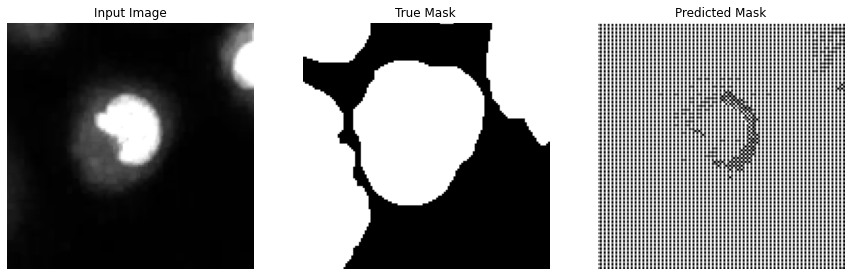

In [ ]:
# predict before training to see what happens
show_predictions(tensorflow_model)

In [ ]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

460
460
52
52


In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(tensorflow_model)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
  
class LearningRateReducerCb(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    old_lr = self.model.optimizer.lr.read_value()
    new_lr = old_lr * 0.99
    print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
    self.model.optimizer.lr.assign(new_lr)


In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

1/1 [==============================] - 0s 20ms/step


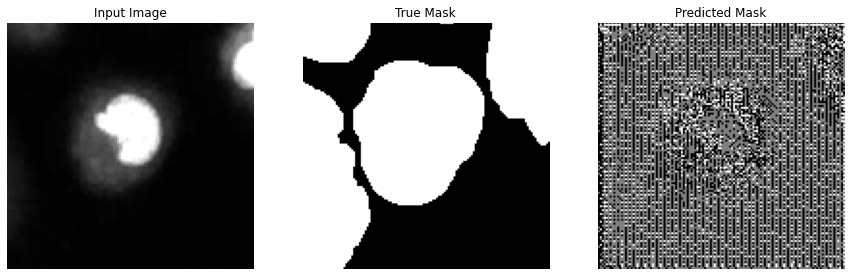


Sample Prediction after epoch 20

230/230 [==============================] - 3s 14ms/step - loss: 0.6879 - accuracy: 0.3205


In [ ]:
# Training Below

TRAIN_LENGTH = len(x_train)
BATCH_SIZE = 2
VAL_SUBSPLITS = 5

EPOCHS = 20
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = STEPS_PER_EPOCH // VAL_SUBSPLITS

tensorflow_model_history = tensorflow_model.fit(
                                                x_train,
                                                y_train, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                callbacks=[DisplayCallback()],
                                                validation_steps=VALIDATION_STEPS,
                                                validation_data=(x_test, y_test)
                                                )




# MeanIOU Score

In [ ]:
#IOU
y_pred = tensorflow_model.predict(x_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU score is: ", iou_score)

2/2 [==============================] - 1s 520ms/step
IoU score is:  0.18835465905874196


Let's double check that:

In [ ]:
len(y_test)

52

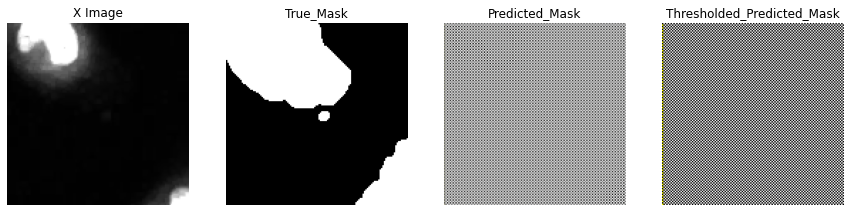

In [ ]:
position = 6
array = [ x_test[position], y_test[position], y_pred[position], y_pred_thresholded[position] ]
labels = ["X Image", "True_Mask", "Predicted_Mask", "Thresholded_Predicted_Mask"]

display( array, labels )

Okay! Despite our best attempts, this procedure is not working. The technique with IoU score may be worth investigating further though

Before we stop this notebook and return to our dataset, let us try 1 more model, with 100 epochs and a learning rate that decreases:

In [ ]:
OUTPUT_CLASSES = 3 # notice output classes
tensorflow_model_2 = unet_model(output_channels=OUTPUT_CLASSES)

# RMSprop compiler
tensorflow_model_2.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

1/1 [==============================] - 1s 755ms/step


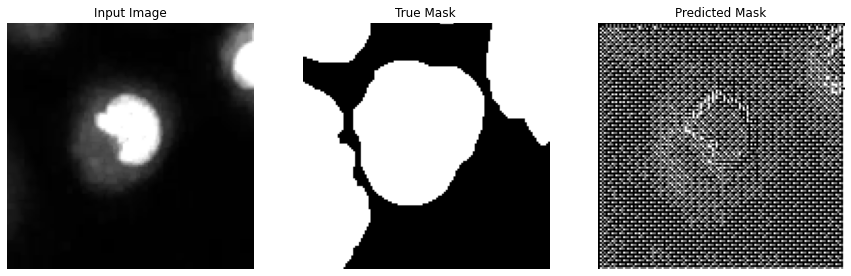

In [ ]:
# predict before training to see what happens
show_predictions(tensorflow_model_2)

1/1 [==============================] - 0s 19ms/step


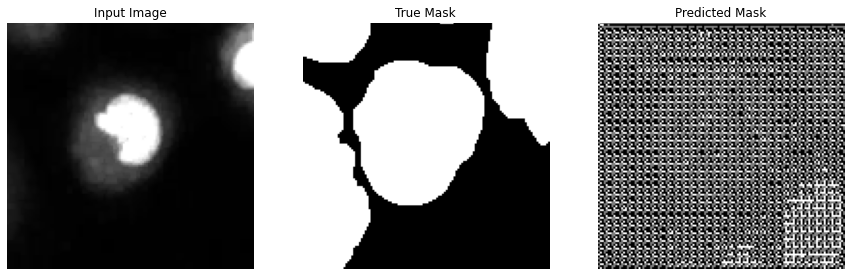


Sample Prediction after epoch 100


Epoch: 99. Reducing Learning Rate from 0.0003697299980558455 to 0.00036603270564228296
230/230 [==============================] - 3s 14ms/step - loss: 0.6750 - accuracy: 0.3158


In [ ]:
# Training Below

TRAIN_LENGTH = len(x_train)
BATCH_SIZE = 2
VAL_SUBSPLITS = 5

EPOCHS = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = STEPS_PER_EPOCH // VAL_SUBSPLITS

tensorflow_model_2_history = tensorflow_model_2.fit(
                                                    x_train,
                                                    y_train, 
                                                    epochs=EPOCHS,
                                                    steps_per_epoch=STEPS_PER_EPOCH,
                                                    callbacks=[DisplayCallback(), LearningRateReducerCb()],
                                                    validation_steps=VALIDATION_STEPS,
                                                    validation_data=(x_test, y_test)
                                                    )




In [ ]:
#IOU
y_pred_2 = tensorflow_model_2.predict(x_test)
y_pred_thresholded_2 = y_pred_2 > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded_2)
union = np.logical_or(y_test, y_pred_thresholded_2)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU score is: ", iou_score)

2/2 [==============================] - 0s 55ms/step
IoU score is:  0.11344726454919779


Let's double check that:

In [ ]:
len(y_test)

52

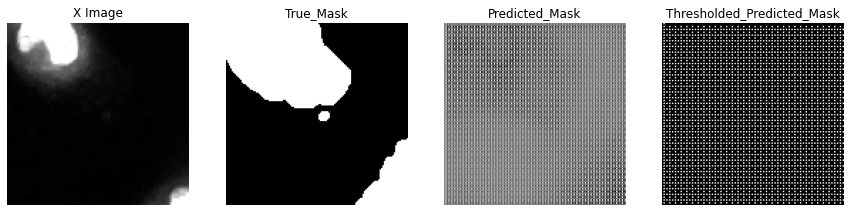

In [ ]:
position = 6
array = [ x_test[position], y_test[position], y_pred_2[position], y_pred_thresholded_2[position] ]
labels = ["X Image", "True_Mask", "Predicted_Mask", "Thresholded_Predicted_Mask"]

display( array, labels )

Yes, the next step is to focus on the preprocessing of the images and return to this later.